In [1]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import warnings

### Fig. 2

In [45]:
#write out newvalue_future and _historical and sumbin_future and _historical
import xarray as xr
import numpy as np
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

models = ["GAM", "GBM"]
taxas = ["Bird", "Mammals", "Amphibians"]
scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_time = 35

year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for time in [historical_time, future_time]:
    for scenario in scenarios:
        # Create empty arrays for storing the results for each taxa separately
        diff_value_bin_combined_per_taxa = {}
        diff_sum_bin_combined_per_taxa = {}
        diff_combined_per_taxa = {}

        for taxa in taxas:
            diff_value_bin_combined_per_taxa[taxa] = np.zeros([360, 720])
            diff_sum_bin_combined_per_taxa[taxa] = np.zeros([360, 720])
            diff_combined_per_taxa[taxa] = np.zeros([360, 720])

        # Initialize the combined arrays outside the taxa loop
        diff_value_bin_combined = np.zeros([360, 720])
        diff_sum_bin_combined = np.zeros([360, 720])
        diff_combined = np.zeros([360, 720])

        for row, taxa in enumerate(taxas):
            # Reset the per model arrays for each taxa
            diff_value_bin_models = []
            diff_sum_bin_models = []
            diff_models = []
            percent_changes = []

            for model in models:
                newvalue_path = f"/storage/scratch/users/ch21o450/data/SR/{taxa}_{model}_{time}_{scenario}_summedprobs_newvalue.nc"
                sumbin_path = f"/storage/scratch/users/ch21o450/data/SR/{taxa}_{model}_{time}_{scenario}_summedprobs_sum.nc"

                mean_value_bin = xr.open_dataset(newvalue_path, decode_times=False).to_array().isel(variable=0)
                mean_sum_bin = xr.open_dataset(sumbin_path, decode_times=False).to_array().isel(variable=0)

                # Calculate the differences
                diff_value_bin = mean_value_bin
                diff_sum_bin = mean_sum_bin
                diff = diff_sum_bin - diff_value_bin
                change_percent = ((diff_sum_bin - diff_value_bin) / (diff_value_bin)) * 100
                percent_changes.append(change_percent)

                # append the differences to the model-specific lists
                diff_value_bin_models.append(diff_value_bin)
                diff_sum_bin_models.append(diff_sum_bin)
                diff_models.append(diff)

            # Calculate the ensemble mean outside of the innermost loop
            diff_value_bin_ensemble = xr.concat(diff_value_bin_models, dim="ensemble").mean(dim="ensemble")
            diff_sum_bin_ensemble = xr.concat(diff_sum_bin_models, dim="ensemble").mean(dim="ensemble")

            diff_value_bin_ensemble = diff_value_bin_ensemble
            diff_sum_bin_ensemble = diff_sum_bin_ensemble
            diff_ensemble = diff_sum_bin_ensemble - diff_value_bin_ensemble

            # Append the ensemble mean to the overall results for this taxa
            diff_value_bin_combined_per_taxa[taxa] = diff_value_bin_ensemble
            diff_sum_bin_combined_per_taxa[taxa] = diff_sum_bin_ensemble
            diff_combined_per_taxa[taxa] = diff_ensemble

        # Calculate the overall species richness sum over all taxa
        diff_value_bin_combined = sum(diff_value_bin_combined_per_taxa.values())
        diff_sum_bin_combined = sum(diff_sum_bin_combined_per_taxa.values())
        diff_combined = sum(diff_combined_per_taxa.values())

        diff_newvalue = diff_value_bin_combined
        diff_sumbin = diff_sum_bin_combined
        diff_combined = diff_combined

        # Get rid of fine line at equator
        land_sea_mask = xr.open_dataset("/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126.nc", decode_times=False).primf
        diff_newvalue_masked = diff_newvalue.where(land_sea_mask >= 0)
        diff_newvalue = diff_newvalue_masked.isel(time=0)

        output_path_diff_newvalue = f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{time}_{scenario}.nc"
        diff_newvalue.to_netcdf(output_path_diff_newvalue, format='NETCDF4')

        # Write out diff_sumbin as netCDF
        output_path_diff_sumbin = f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{time}_{scenario}.nc"
        diff_sumbin.to_netcdf(output_path_diff_sumbin, format='NETCDF4')


PermissionError: [Errno 13] Permission denied: b'/storage/scratch/users/ch21o450/data/SR/SR_CC_1146_rcp26.nc'

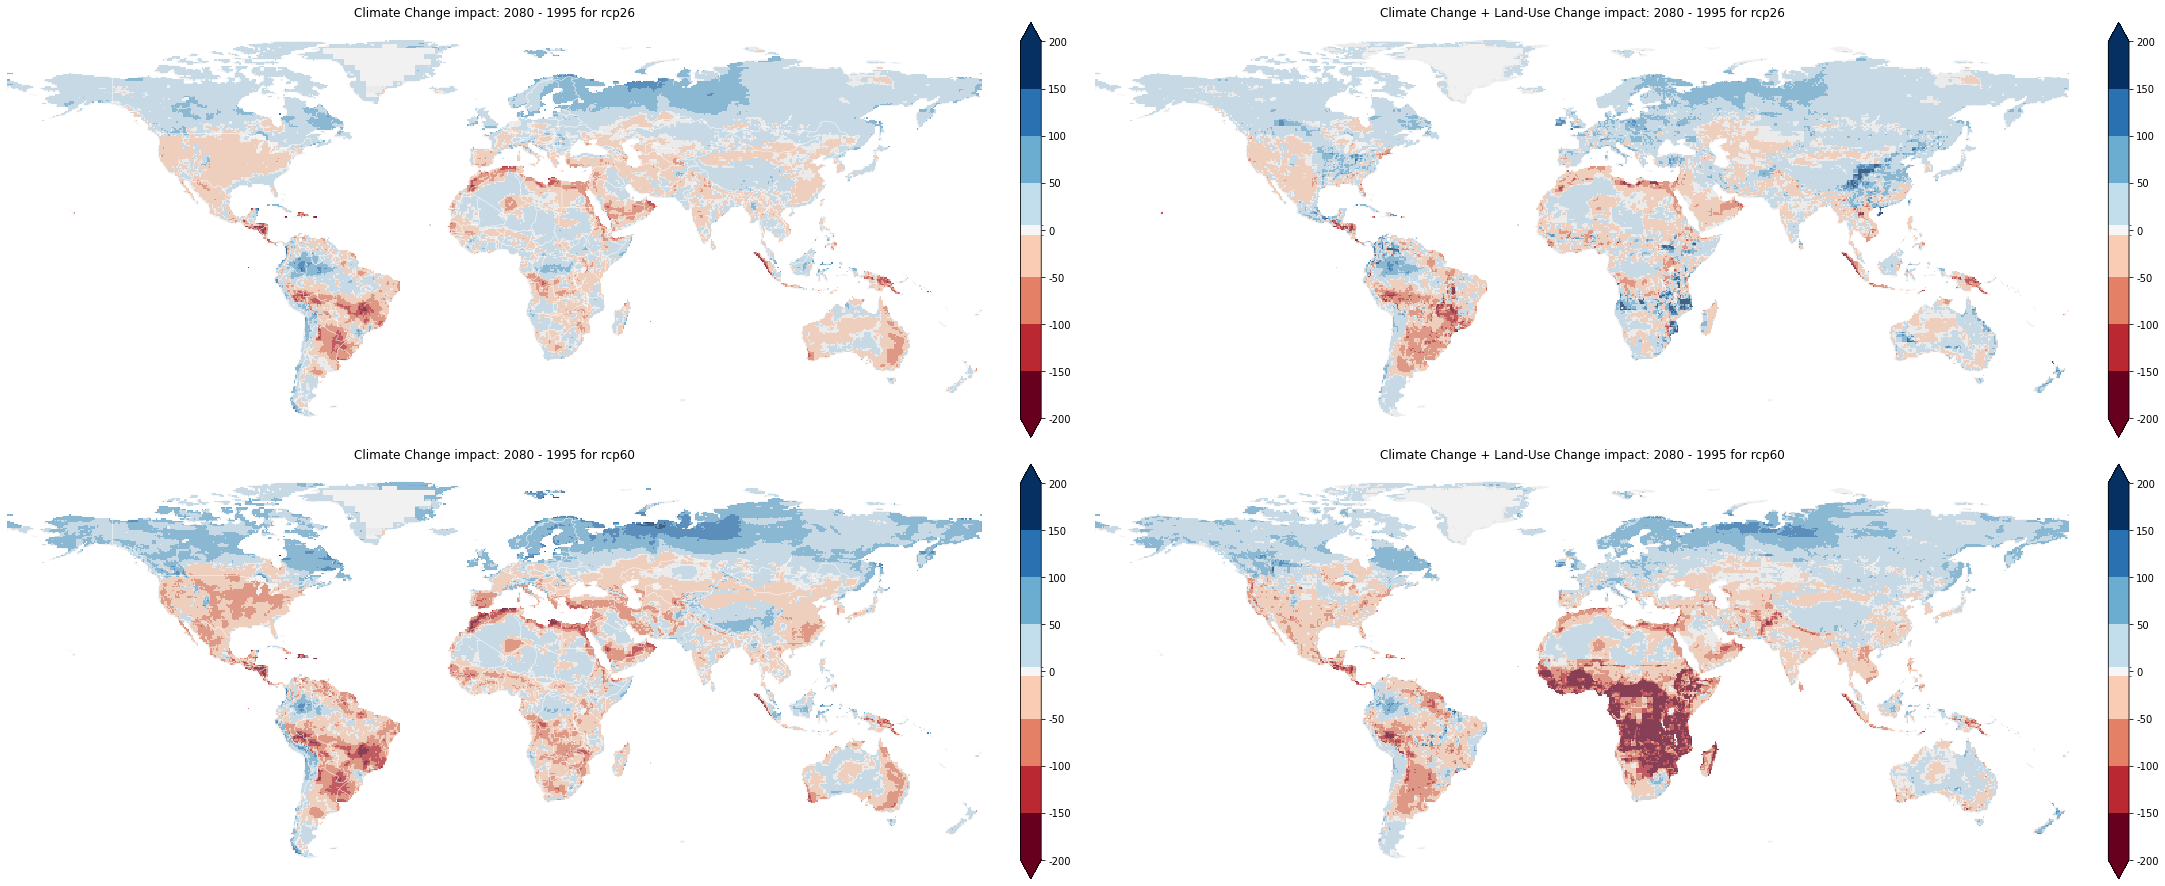

In [7]:
#read in newvalue_future and _historical and sumbin_future and _historical and plot

warnings.filterwarnings('ignore', category=UserWarning)


scenarios = ["rcp26","rcp60"]
historical_time= 1146
future_time=65

year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0

for row, scenario in enumerate(scenarios):

    newvalue_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(time=0)
    sumbin_future= sumbin_future.isel(variable=0)

    newvalue_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
    sumbin_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)

    diff_newvalue = newvalue_future - newvalue_hist
    diff_sumbin = sumbin_future - sumbin_hist
    
    if plot_idx >= len(axes.flatten()):
        break
    ax1 = axes.flatten()[plot_idx]
    ax2 = axes.flatten()[plot_idx + 1]

    labels = ['a', 'b']
    # Define the colormap and the range of values for the colorbar

    #vmin_b = diff_sum_bin.min().values
    #vmax_b = diff_sum_bin.max().values

    cmap = plt.colormaps['RdBu']
    boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)

    # Plot the ensemble mean difference for each panel
    im1 = ax1.pcolormesh(diff_newvalue['lon'].values, diff_newvalue['lat'].values, np.where(diff_newvalue.values != 0, diff_newvalue.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.3)
    ax1.set_title(f"Climate Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax1.axis('off')
    ax1.set_extent((-180,180,-63,90))
    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
    tick_labels = [str(int(tick)) for tick in ticks_b]

    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar1.set_ticklabels(tick_labels)

    im2 = ax2.pcolormesh(diff_sumbin['lon'].values, diff_sumbin['lat'].values,  np.where(diff_sumbin.values != 0, diff_sumbin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax2, color="lightgrey", zorder=1, alpha=0.3)

    ax2.set_title(f"Climate Change + Land-Use Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax2.axis('off')
    ax2.set_extent((-180,180,-63,90))
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar2.set_ticklabels(tick_labels)

    # Increase the plot index by 2 to move to the next triplet of subplots
    plot_idx += 2

#plt.suptitle(future_time , size=16, y=0.8)
#plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Figure_2")

plt.show() 


In [5]:
diff_newvalue.mean()

<xarray.DataArray ()>
array(6.09361183)
Coordinates:
    variable  <U29 '__xarray_dataarray_variable__'
    time      float64 0.0

In [6]:
diff_sumbin.mean()

<xarray.DataArray ()>
array(-1.28188296)
Coordinates:
    variable  <U29 '__xarray_dataarray_variable__'

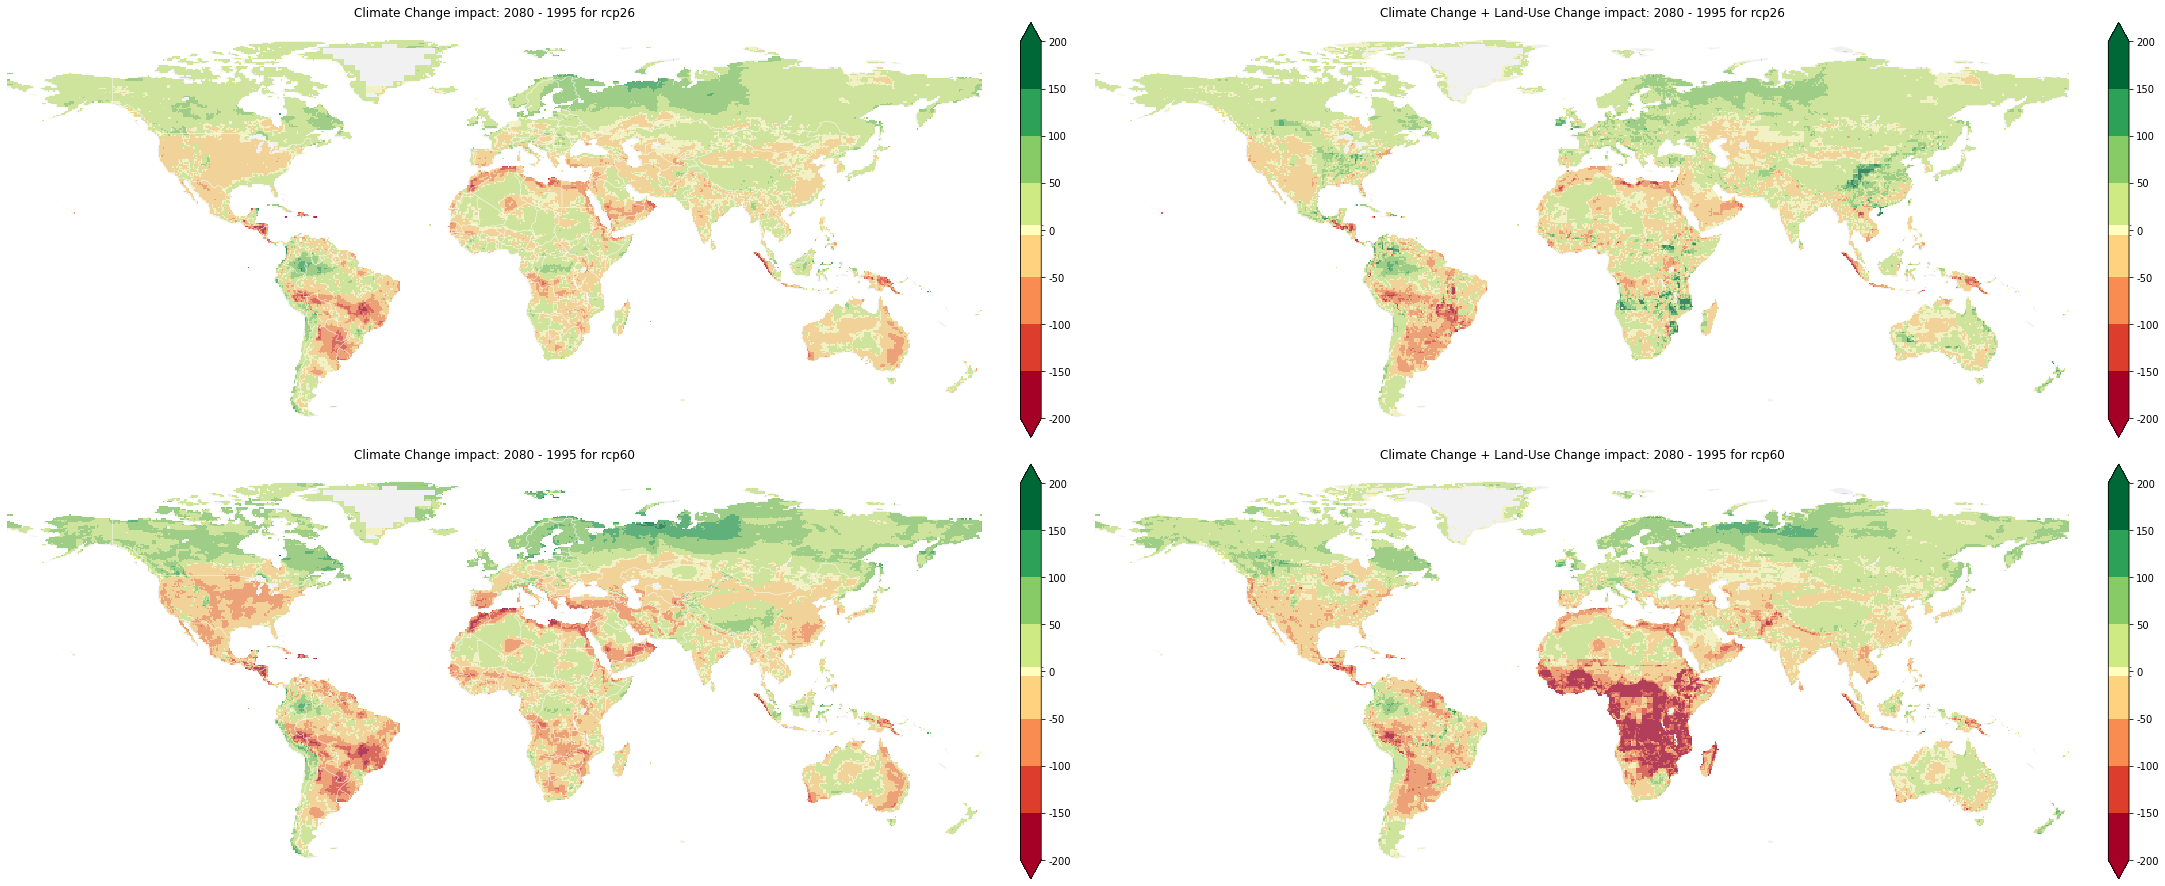

In [15]:
#plot results sensitivity analysis

warnings.filterwarnings('ignore', category=UserWarning)


scenarios = ["rcp26","rcp60"]
historical_time= 1146
future_time=65

years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0

for row, scenario in enumerate(scenarios):

    newvalue_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{future_time}_{scenario}_SA.nc", decode_times=False).to_array().isel(variable=0)
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{future_time}_{scenario}_SA.nc", decode_times=False).to_array().isel(variable=0)
    #sumbin_future= sumbin_future.isel(variable=0)

    newvalue_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{historical_time}_{scenario}_SA.nc", decode_times=False).to_array().isel(variable=0)
    sumbin_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{historical_time}_{scenario}_SA.nc", decode_times=False).to_array().isel(variable=0)

    diff_newvalue = newvalue_future - newvalue_hist
    diff_sumbin = sumbin_future - sumbin_hist
    
    if plot_idx >= len(axes.flatten()):
        break
    ax1 = axes.flatten()[plot_idx]
    ax2 = axes.flatten()[plot_idx + 1]

    labels = ['a', 'b']
    # Define the colormap and the range of values for the colorbar

    #vmin_b = diff_sum_bin.min().values
    #vmax_b = diff_sum_bin.max().values

    cmap = plt.colormaps['RdYlGn']
    boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)

    # Plot the ensemble mean difference for each panel
    im1 = ax1.pcolormesh(diff_newvalue['lon'].values, diff_newvalue['lat'].values, np.where(diff_newvalue.values != 0, diff_newvalue.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.3)
    ax1.set_title(f"Climate Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax1.axis('off')
    ax1.set_extent((-180,180,-63,90))
    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
    tick_labels = [str(int(tick)) for tick in ticks_b]

    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar1.set_ticklabels(tick_labels)

    im2 = ax2.pcolormesh(diff_sumbin['lon'].values, diff_sumbin['lat'].values,  np.where(diff_sumbin.values != 0, diff_sumbin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax2, color="lightgrey", zorder=1, alpha=0.3)

    ax2.set_title(f"Climate Change + Land-Use Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax2.axis('off')
    ax2.set_extent((-180,180,-63,90))
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar2.set_ticklabels(tick_labels)

    # Increase the plot index by 2 to move to the next triplet of subplots
    plot_idx += 2

#plt.suptitle(future_time , size=16, y=0.8)
#plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Figure_2")

plt.show() 


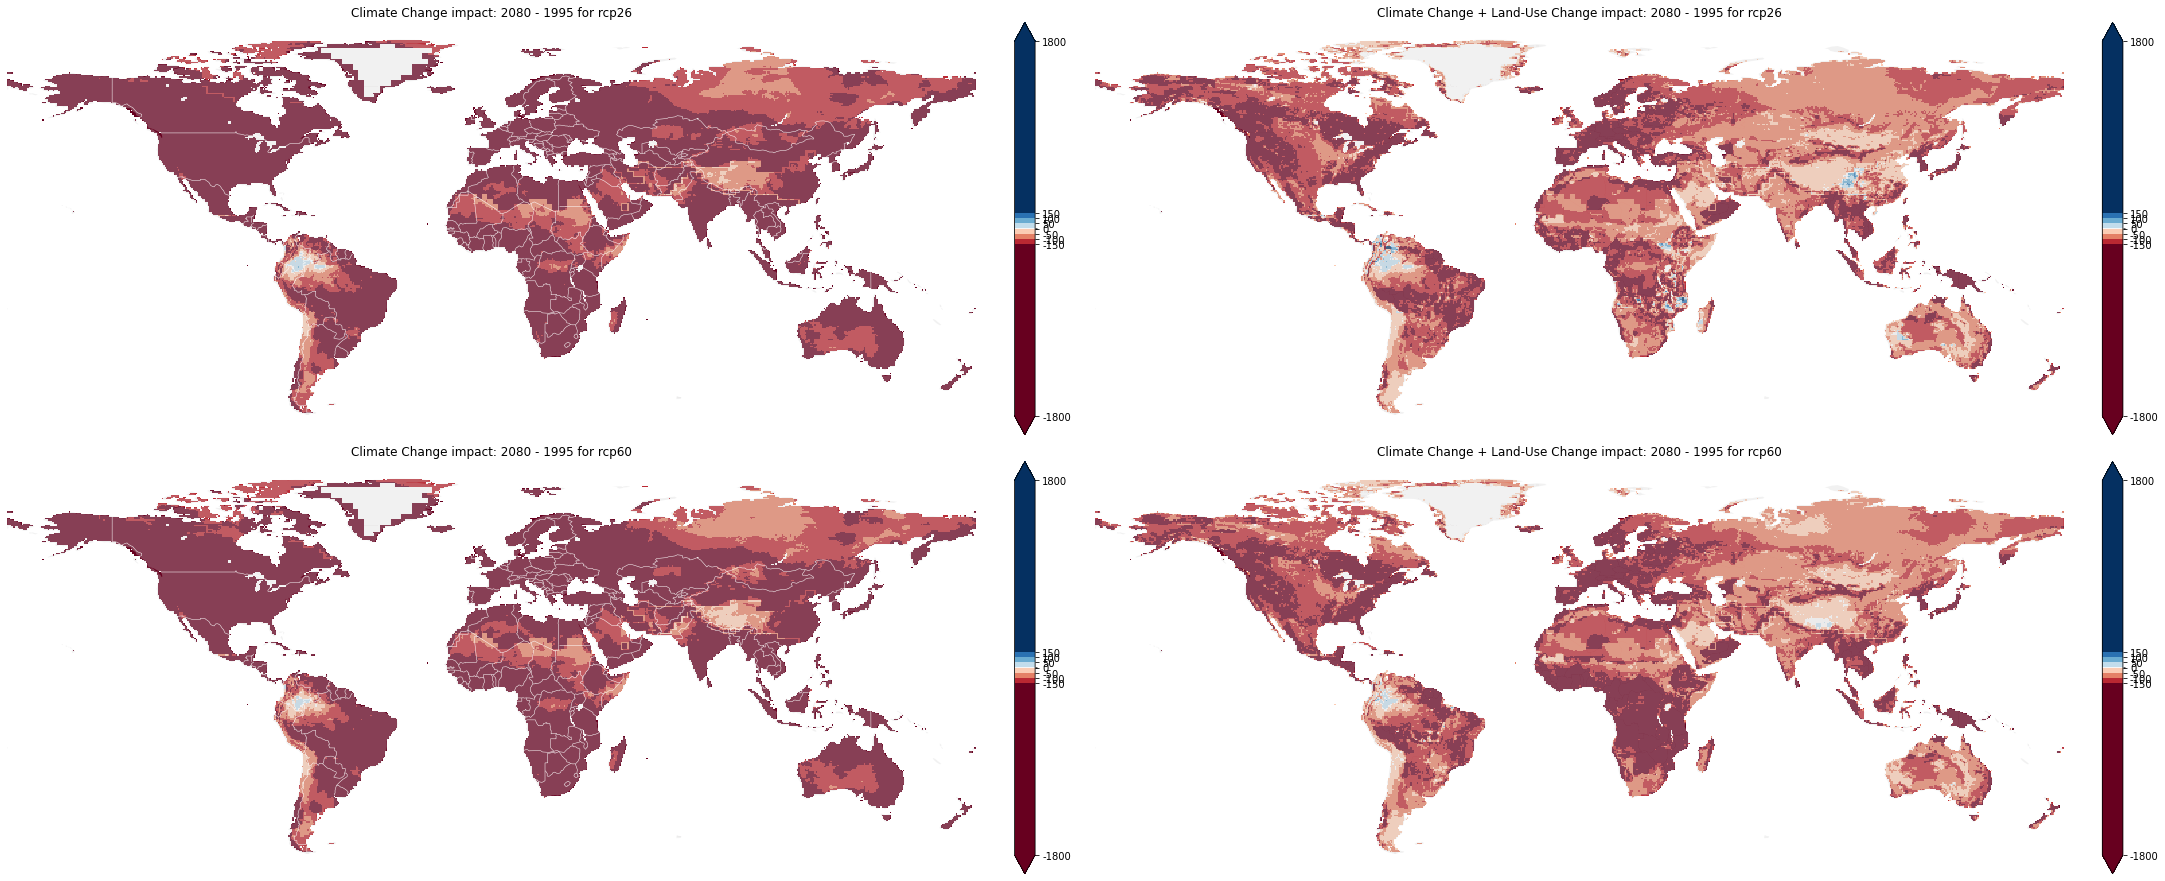

In [41]:
#plot results dispersal

warnings.filterwarnings('ignore', category=UserWarning)


scenarios = ["rcp26","rcp60"]
historical_time= 1146
future_time=65

years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0

for row, scenario in enumerate(scenarios):

    newvalue_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{future_time}_{scenario}_dispersal2.nc", decode_times=False).to_array().isel(variable=0)
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{future_time}_{scenario}_dispersal2.nc", decode_times=False).to_array().isel(variable=0)
    #sumbin_future= sumbin_future.isel(variable=0)

    newvalue_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
    sumbin_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)

    diff_newvalue = newvalue_future - newvalue_hist
    diff_sumbin = sumbin_future - sumbin_hist
    
    if plot_idx >= len(axes.flatten()):
        break
    ax1 = axes.flatten()[plot_idx]
    ax2 = axes.flatten()[plot_idx + 1]

    labels = ['a', 'b']
    # Define the colormap and the range of values for the colorbar

    #vmin_b = diff_sum_bin.min().values
    #vmax_b = diff_sum_bin.max().values

    cmap = plt.colormaps['RdBu']
    boundaries = [-1800, -150, -100, -50,-5,5,50, 100, 150, 1800] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)

    # Plot the ensemble mean difference for each panel
    im1 = ax1.pcolormesh(diff_newvalue['lon'].values, diff_newvalue['lat'].values, np.where(diff_newvalue.values != 0, diff_newvalue.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.3)
    ax1.set_title(f"Climate Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax1.axis('off')
    ax1.set_extent((-180,180,-63,90))
    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

    ticks_b = np.array( [-1800, -150, -100, -50,0,50, 100, 150, 1800])
    tick_labels = [str(int(tick)) for tick in ticks_b]

    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar1.set_ticklabels(tick_labels)

    im2 = ax2.pcolormesh(diff_sumbin['lon'].values, diff_sumbin['lat'].values,  np.where(diff_sumbin.values != 0, diff_sumbin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax2, color="lightgrey", zorder=1, alpha=0.3)

    ax2.set_title(f"Climate Change + Land-Use Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax2.axis('off')
    ax2.set_extent((-180,180,-63,90))
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar2.set_ticklabels(tick_labels)

    # Increase the plot index by 2 to move to the next triplet of subplots
    plot_idx += 2

#plt.suptitle(future_time , size=16, y=0.8)
#plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Figure_2")

plt.show() 


FileNotFoundError: [Errno 2] No such file or directory: b'/storage/scratch/users/ch21o450/data/SR/cc_85_rcp60.nc'

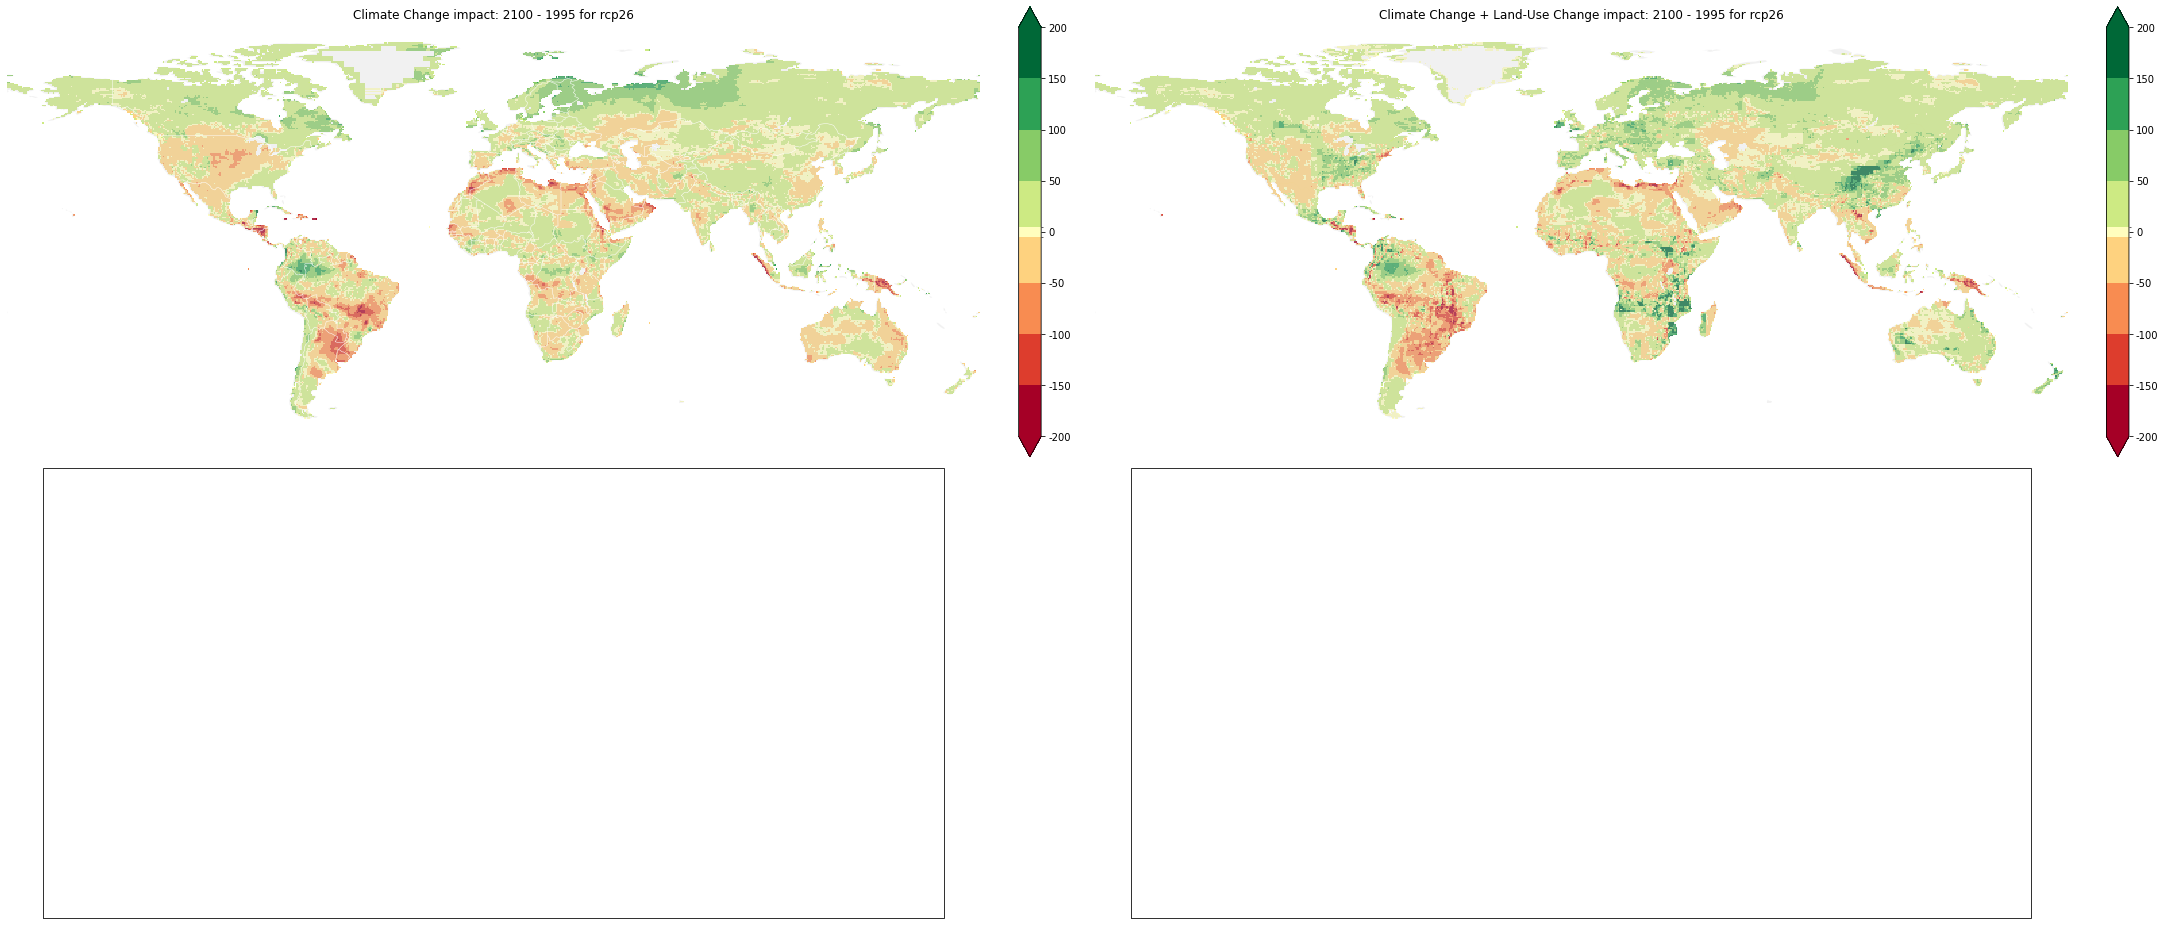

In [44]:
#plot 2100

warnings.filterwarnings('ignore', category=UserWarning)


scenarios = ["rcp26","rcp60"]
historical_time= 1146
future_time=85

years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0

for row, scenario in enumerate(scenarios):

    newvalue_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/cc_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/ccluc_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(time=0)
    sumbin_future= sumbin_future.isel(variable=0)

    newvalue_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
    sumbin_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)

    diff_newvalue = newvalue_future - newvalue_hist
    diff_sumbin = sumbin_future - sumbin_hist
    
    if plot_idx >= len(axes.flatten()):
        break
    ax1 = axes.flatten()[plot_idx]
    ax2 = axes.flatten()[plot_idx + 1]

    labels = ['a', 'b']
    # Define the colormap and the range of values for the colorbar

    #vmin_b = diff_sum_bin.min().values
    #vmax_b = diff_sum_bin.max().values

    cmap = plt.colormaps['RdYlGn']
    boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)

    # Plot the ensemble mean difference for each panel
    im1 = ax1.pcolormesh(diff_newvalue['lon'].values, diff_newvalue['lat'].values, np.where(diff_newvalue.values != 0, diff_newvalue.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.3)
    ax1.set_title(f"Climate Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax1.axis('off')
    ax1.set_extent((-180,180,-63,90))
    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
    tick_labels = [str(int(tick)) for tick in ticks_b]

    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar1.set_ticklabels(tick_labels)

    im2 = ax2.pcolormesh(diff_sumbin['lon'].values, diff_sumbin['lat'].values,  np.where(diff_sumbin.values != 0, diff_sumbin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax2, color="lightgrey", zorder=1, alpha=0.3)

    ax2.set_title(f"Climate Change + Land-Use Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax2.axis('off')
    ax2.set_extent((-180,180,-63,90))
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar2.set_ticklabels(tick_labels)

    # Increase the plot index by 2 to move to the next triplet of subplots
    plot_idx += 2

#plt.suptitle(future_time , size=16, y=0.8)
#plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Figure_2")

plt.show() 


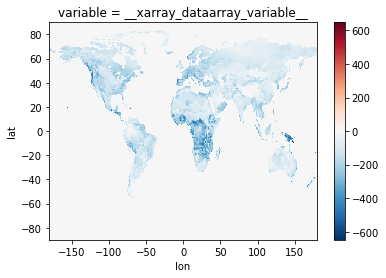

In [42]:
diff_sumbin.plot()

In [4]:
# Calculate the absolute difference between the two plots
absolute_difference = np.abs(diff_sumbin.values - diff_newvalue.values)

# Calculate mean, maximum, and standard deviation of the absolute difference
mean_diff = np.nanmean(absolute_difference)
max_diff = np.nanmax(absolute_difference)
std_diff = np.nanstd(absolute_difference)

# Print the summary statistics
print(f"Summary statistics for absolute difference between the two plots:")
print(f"Mean difference: {mean_diff:.2f}")
print(f"Maximum difference: {max_diff:.2f}")
print(f"Standard deviation of difference: {std_diff:.2f}")


Summary statistics for absolute difference between the two plots:
Mean difference: 15.31
Maximum difference: 895.80
Standard deviation of difference: 62.96


In [66]:
# Calculate the relative difference between the two plots

abs_difference = abs(diff_sumbin - diff_newvalue)
relative_difference = np.where(diff_newvalue != 0,
                               abs_difference / diff_newvalue * 100,
                               np.nan)

# Calculate mean, maximum, and standard deviation of the relative difference
mean_relative_diff = np.nanmean(relative_difference)
max_relative_diff = np.nanmax(relative_difference)
std_relative_diff = np.nanstd(relative_difference)

# Print the summary statistics
print(f"Summary statistics for relative difference between the two plots (%):")
print(f"Mean relative difference: {mean_relative_diff:.2f}%")
print(f"Maximum relative difference: {max_relative_diff:.2f}%")
print(f"Standard deviation of relative difference: {std_relative_diff:.2f}%")


Summary statistics for relative difference between the two plots (%):
Mean relative difference: 9.95%
Maximum relative difference: 1484687.36%
Standard deviation of relative difference: 20463.85%


In [85]:
# Calculate the relative difference between the two plots

abs_difference = abs(diff_newvaluercp26 - diff_newvaluercp60)
relative_difference = np.where(diff_newvaluercp26 != 0,
                               abs_difference / diff_newvaluercp26 * 100,
                               np.nan)

# Calculate mean, maximum, and standard deviation of the relative difference
mean_relative_diff = np.nanmean(relative_difference)
max_relative_diff = np.nanmax(relative_difference)
std_relative_diff = np.nanstd(relative_difference)

# Print the summary statistics
print(f"Summary statistics for relative difference between the two plots (%):")
print(f"Mean relative difference: {mean_relative_diff:.2f}%")
print(f"Maximum relative difference: {max_relative_diff:.2f}%")
print(f"Standard deviation of relative difference: {std_relative_diff:.2f}%")


Summary statistics for relative difference between the two plots (%):
Mean relative difference: -290008178085.29%
Maximum relative difference: 939900.00%
Standard deviation of relative difference: 71426841628860.33%


In [80]:
t=diff_between_scenarios/diff_combined_all_scenarios[0]

In [85]:
percentage_diff = (diff_between_scenarios / diff_combined_all_scenarios[0]) * 100

In [87]:
with np.errstate(divide='ignore', invalid='ignore'):
    percentage_diff = (diff_between_scenarios / diff_combined_all_scenarios[0]) * 100
    percentage_diff = xr.where(diff_combined_all_scenarios[0] == 0, np.nan, percentage_diff)


In [88]:
percentage_diff.mean()

<xarray.DataArray ()>
array(3329232.40808478)
Coordinates:
    time      float64 35.0
    variable  <U7 'sum_bin'

In [46]:
diff*100

0.2734878966165012

In [39]:
perc.mean()

0.0027348789661650053

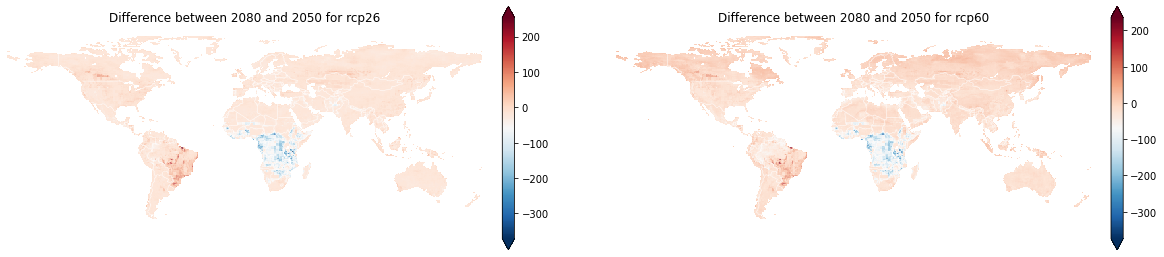

In [90]:
# ... [the beginning parts of your code remain unchanged]

# Setup plot
fig, axes = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

for idx, scenario in enumerate(scenarios):
    diff_2080_2050_per_taxa = {taxa: np.zeros([360, 720]) for taxa in taxas}
    
    for taxa in taxas:
        newvalue_2050 = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_35_{scenario}_species_count_per_SCDM_00th_mean_sum_bin_future.nc"
        newvalue_2080 = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_65_{scenario}_species_count_per_SCDM_00th_mean_sum_bin_future.nc"

        mean_value_bin_2050 = xr.open_dataset(newvalue_2050, decode_times=False).to_array()
        mean_value_bin_2080 = xr.open_dataset(newvalue_2080, decode_times=False).to_array()

        diff_2080_2050 = mean_value_bin_2080 - mean_value_bin_2050
        diff_2080_2050_per_taxa[taxa] = diff_2080_2050.isel(variable=0)
    
    # Sum across all taxa
    diff_2080_2050_combined = sum(diff_2080_2050_per_taxa.values())
    
    # Plotting
    ax = axes[idx]

    cmap = plt.cm.RdBu_r
    im = ax.pcolormesh(diff_2080_2050_combined['lon'].values, diff_2080_2050_combined['lat'].values, np.where(diff_2080_2050_combined.values != 0, diff_2080_2050_combined.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap)

    countries.plot(ax=ax, color="white", zorder=1, alpha=0.3)
    ax.set_title(f"Difference between 2080 and 2050 for {scenario}", loc='center')

    ax.axis('off')
    ax.set_extent((-180, 180, -63, 90))
    ax.add_feature(cfeature.BORDERS, color='white', linewidth=0.5)

    cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04, spacing='proportional', extend='both')

plt.show()


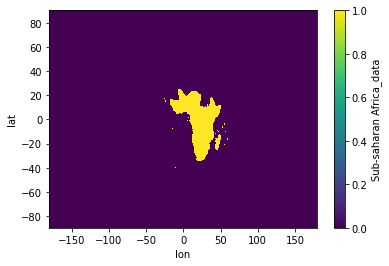

In [77]:
sub_africa.plot()

In [ ]:
#read in newvalue_future and _historical and sumbin_future and _historical and plot

warnings.filterwarnings('ignore', category=UserWarning)


scenarios = ["rcp26","rcp60"]
historical_time= 1146
future_time=65

years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0

#sub_africa = sub_africa.rename({'latitude': 'lat', 'longitude': 'lon'})

for row, scenario in enumerate(scenarios):

    newvalue_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(time=0)
    sumbin_future= sumbin_future.isel(variable=0)

    newvalue_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
    sumbin_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
    



    diff_newvalue = newvalue_future - newvalue_hist
    diff_sumbin = sumbin_future - sumbin_hist
    
    if plot_idx >= len(axes.flatten()):
        break
    ax1 = axes.flatten()[plot_idx]
    ax2 = axes.flatten()[plot_idx + 1]

    labels = ['a', 'b']
    # Define the colormap and the range of values for the colorbar

    #vmin_b = diff_sum_bin.min().values
    #vmax_b = diff_sum_bin.max().values

    cmap = plt.colormaps['RdYlGn']
    boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)

    # Plot the ensemble mean difference for each panel
    im1 = ax1.pcolormesh(diff_newvalue['lon'].values, diff_newvalue['lat'].values, np.where(diff_newvalue.values != 0, diff_newvalue.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.3)
    ax1.set_title(f"Climate Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax1.axis('off')
    ax1.set_extent((-180,180,-63,90))
    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
    tick_labels = [str(int(tick)) for tick in ticks_b]

    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar1.set_ticklabels(tick_labels)

    im2 = ax2.pcolormesh(diff_sumbin['lon'].values, diff_sumbin['lat'].values,  np.where(diff_sumbin.values != 0, diff_sumbin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax2, color="lightgrey", zorder=1, alpha=0.3)

    ax2.set_title(f"Climate Change + Land-Use Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax2.axis('off')
    ax2.set_extent((-180,180,-63,90))
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar2.set_ticklabels(tick_labels)

    # Increase the plot index by 2 to move to the next triplet of subplots
    plot_idx += 2

#plt.suptitle(future_time , size=16, y=0.8)
#plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Figure_2")

plt.show() 


In [8]:
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import BoundaryNorm
import warnings

#read in the ipbes region shapefile
shp_dir = "/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/IPBES_Regions_Subregions2.shp"
shp = gpd.read_file(shp_dir) 

#define the new regions
region_mapping = {
    'Antarctica': 'none',
    'Carribean': 'North America',
    'Central Africa': 'Sub-saharan Africa',
    'Central and Western Europe': 'Central and Western Europe',
    'Central Asia': 'Central Asia',
    'East Africa and adjacent islands': 'Sub-saharan Africa',
    'Eastern Europe': 'Eastern Europe',
    'Mesoamerica': 'North America',
    'North Africa': 'North Africa',
    'North America': 'North America',
    'Nort-East Asia': 'Nort-East Asia',
    'Oceania': 'Oceania',
    'South America': 'South America',
    'South Asia': 'South Asia',
    'South-East Asia': 'South-East Asia',
    'Southern Africa': 'Sub-saharan Africa',
    'West Africa': 'Sub-saharan Africa',
    'Western Asia': 'Western Asia'
}

shp['new_region'] = shp['Sub_Region'].map(region_mapping)

In [9]:
newvalue_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_65_rcp60.nc", decode_times=False).to_array().isel(variable=0)

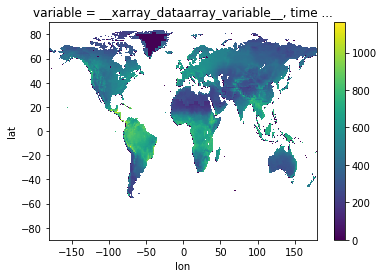

In [10]:
newvalue_future.plot()

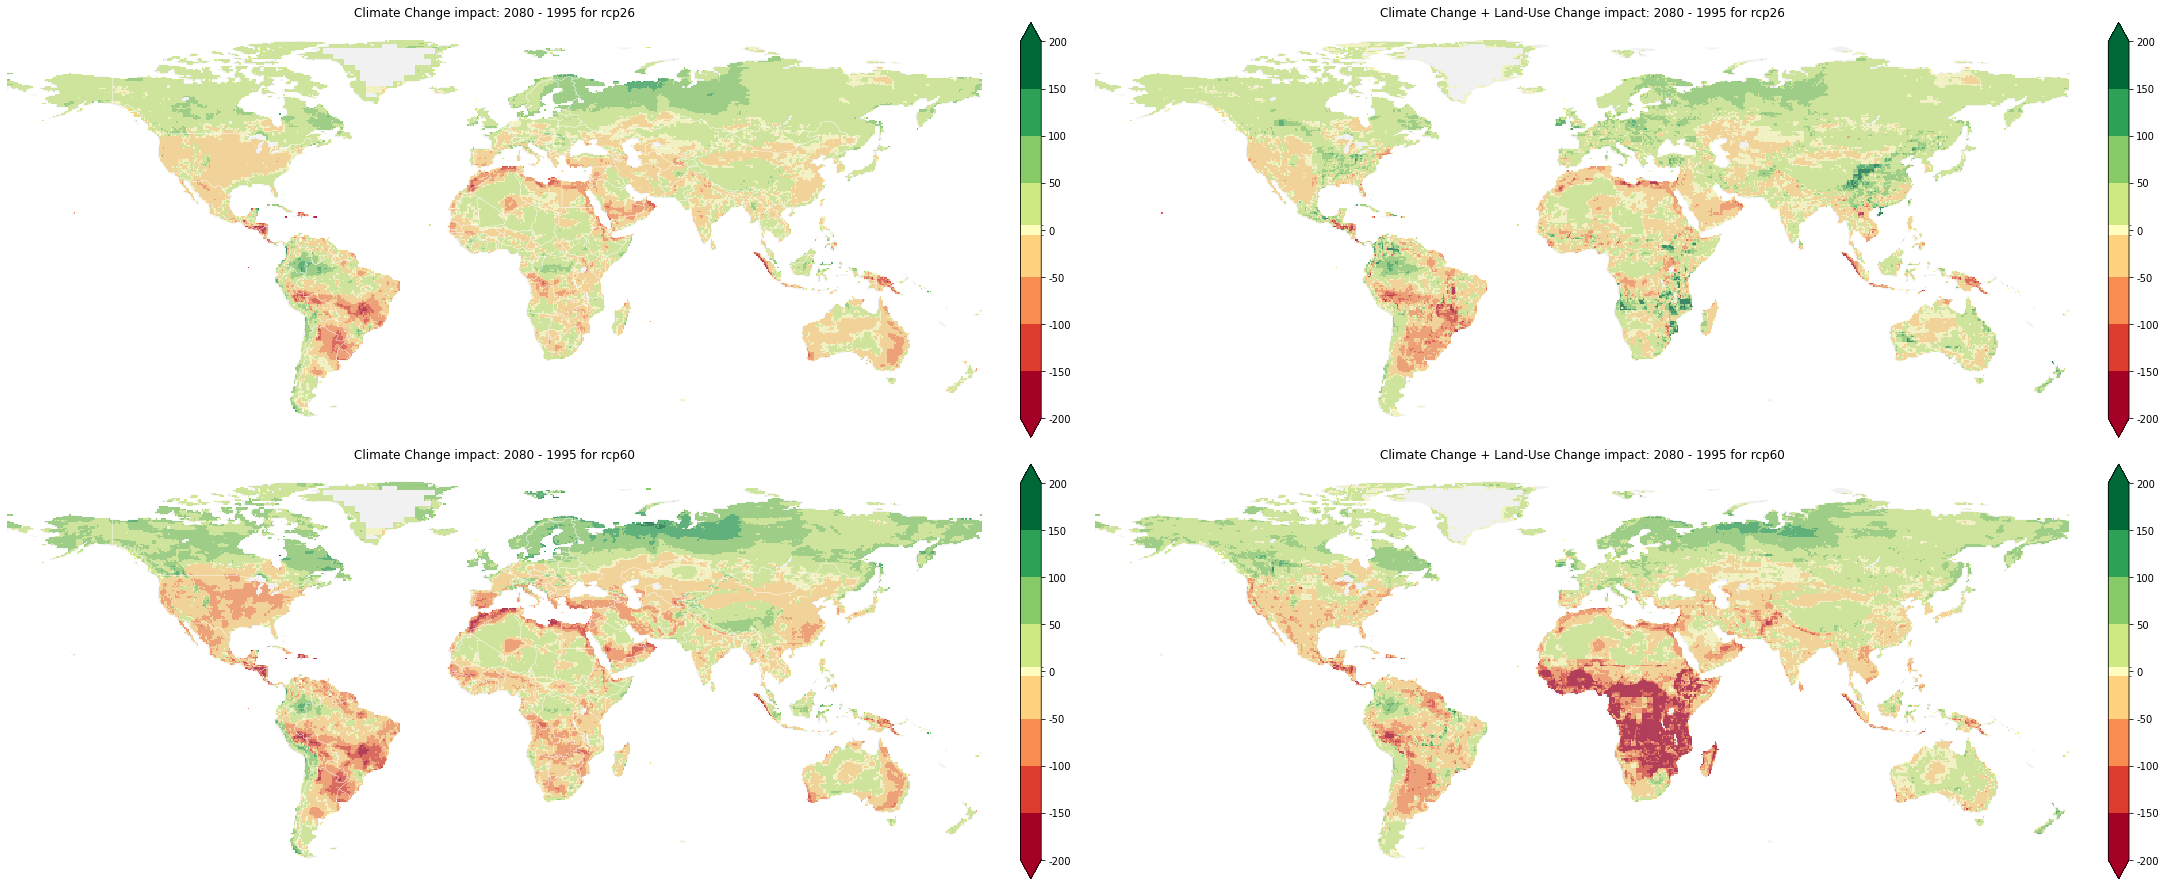

In [11]:
#read in newvalue_future and _historical and sumbin_future and _historical and plot

warnings.filterwarnings('ignore', category=UserWarning)


scenarios = ["rcp26","rcp60"]
historical_time= 1146
future_time=65

years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0

#sub_africa = sub_africa.rename({'latitude': 'lat', 'longitude': 'lon'})

for row, scenario in enumerate(scenarios):

    newvalue_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(time=0)
    sumbin_future= sumbin_future.isel(variable=0)

    newvalue_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
    sumbin_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
    



    diff_newvalue = newvalue_future - newvalue_hist
    diff_sumbin = sumbin_future - sumbin_hist
    
    if plot_idx >= len(axes.flatten()):
        break
    ax1 = axes.flatten()[plot_idx]
    ax2 = axes.flatten()[plot_idx + 1]

    labels = ['a', 'b']
    # Define the colormap and the range of values for the colorbar

    #vmin_b = diff_sum_bin.min().values
    #vmax_b = diff_sum_bin.max().values

    cmap = plt.colormaps['RdYlGn']
    boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)

    # Plot the ensemble mean difference for each panel
    im1 = ax1.pcolormesh(diff_newvalue['lon'].values, diff_newvalue['lat'].values, np.where(diff_newvalue.values != 0, diff_newvalue.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.3)
    ax1.set_title(f"Climate Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax1.axis('off')
    ax1.set_extent((-180,180,-63,90))
    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
    tick_labels = [str(int(tick)) for tick in ticks_b]

    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar1.set_ticklabels(tick_labels)

    im2 = ax2.pcolormesh(diff_sumbin['lon'].values, diff_sumbin['lat'].values,  np.where(diff_sumbin.values != 0, diff_sumbin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax2, color="lightgrey", zorder=1, alpha=0.3)

    ax2.set_title(f"Climate Change + Land-Use Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax2.axis('off')
    ax2.set_extent((-180,180,-63,90))
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar2.set_ticklabels(tick_labels)

    # Increase the plot index by 2 to move to the next triplet of subplots
    plot_idx += 2

#plt.suptitle(future_time , size=16, y=0.8)
#plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Figure_2")

plt.show() 
